# Neural Network Classifier & Regressor

## Overview

This tutorial introduces `NeuralNetworkClassifier` and `NeuralNetworkRegressor` as a solution to `Supervised Machine Learning problems` of classification and regression respectively.

## Introduction

Both `NeuralNetworkClassifier` and `NeuralNetworkRegressor` take a Quantum `NeuralNetwork` as an input and leverage it in a specific context. In both cases, `Quantum Machine Learning` provides a pre-configured variant for convenience, namely the Variational Quantum Classifier (`VQC`) and Variational Quantum Regressor (`VQR`). 

The tutorial is structured as follows:


1. [Classification](#Classification) 
    * Classification with `NeuralNetworkClassifier` using `OpflowQNN` 
    * Classification with `NeuralNetworkClassifier` using `CircuitQNN`
    * Classification with `Variational Quantum Classifier (VQC)`
    
    
2. [Regression](#Regression)
    * Regression with `NeuralNetworkRegressor` using `OpflowQNN` 
    * Regression with `Variational Quantum Regressor (VQR)`

We will start by setting up some utilities like fixing the algorithmic seed to ensure that the results don't change between runs and the quantum instance to evaluate the network.

In [1]:
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit import Aer

# algorithmic seed is set to ensure that the results don't change between runs
algorithm_globals.random_seed = 42

# define the simulator based quantum instance
quantum_instance = QuantumInstance(
    Aer.get_backend("aer_simulator"),
    shots=1024,
    seed_simulator=algorithm_globals.random_seed,
    seed_transpiler=algorithm_globals.random_seed,
)

# The shots to 1024 will determine the number of samples later on

After specifying the common settings, We will add a callback function called `callback_graph`. This is a helper function which will be used in both classification and regression as the `epoch` common in all machine learning problems. 

`callback_graph` will be called for each iteration of the optimizer and will be passed two parameters: 
1. The current weights
2. The value of the objective function at those weights 

For our function, we append the value of the objective function to an array so we can plot iteration versus objective function value and update the graph with each iteration. This graph shows the reducing error with every iteration. However, you can do whatever you want with a callback function as long as it gets the two mentioned parameters passed. 

In [2]:
from IPython.display import clear_output

# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

## 1. Classification

In this section we use `NeuralNetworkClassifier` and `VQC` on Binary Classification. In simplicity, classification is a problem of categorizing a dataset into classes or categories. If there are 2 classes, then it is known as binary classification, and anything more is referred to as multi-class classification. 

Steps that will be followed in the classification section
1. First, we prepare a simple classification dataset to illustrate the following algorithms. 
2. Next we implement `NeuralNetworkClassifier` to solve the machine learning problem using `TwoLayerQNN` 
3. Followed by implementation of `NeuralNetworkClassifier` to solve the machine learning problem using `CircuitQNN`.
4. Afterwards we implement `VQC` to solve the same problem. `VQC` is essentially a wrapper class that inherits from `NeuralNetworkClassifier` and pre configures a parameterized circuit. 
5. As a final bonus, we solve multi-class classification problem using `VQC`.

### 1.1. Dataset preparation for classification

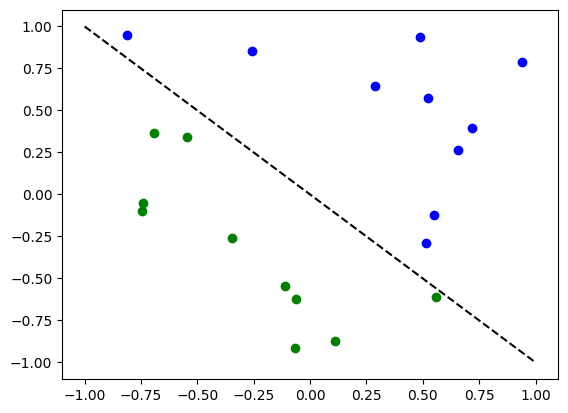

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Generation of input dataset for classification

num_inputs = 2
num_samples = 20


# Step 1.1: Generating num_sample (20) pairs (num_input is 2) of random numbers as X

X = algorithm_globals.random.random(
    [num_samples, num_inputs]
)  # All random values are in range (0,1)
X = 2 * X - 1  # This changes the range of random values from (0,1) to (-1,+1)


# Step 1.2: Generating y from x
# np.sum(X, axis=1) >= 0 This sums each row and returns True if sum >= 0, else False is returned

y01 = 1 * (np.sum(X, axis=1) >= 0)  # Here, {True or False} is converted to {0 or 1}
y = 2 * y01 - 1  # Here, {0 or 1} is converted to {-1 or +1}


# Step 1.3: One hot encoding of y

# Generating num_sample (20) pairs (2) of zeros
y_one_hot = np.zeros((num_samples, 2))

# Implement One hot encoding based on y01 values i.e {True or False}
for i in range(num_samples):
    y_one_hot[i, y01[i]] = 1


# Step 1.4: Plotting the generated dataset as scatterplot
for x, y_target in zip(X, y):
    if y_target == 1:
        # class +1
        plt.plot(x[0], x[1], "bo")
    else:
        # class -1
        plt.plot(x[0], x[1], "go")
# line of classification
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

### 1.2. Classification with `NeuralNetworkClassifier` using `OpflowQNN`

Here, we demonstrate how an `OpflowQNN` can be used for classification within a `NeuralNetworkClassifier`. In this context, the `OpflowQNN` is expected to return one-dimensional output in $[-1, +1]$. This only works for binary classification, by assigning the two classes to $\{-1, +1\}$. 

For convenience, we use the `TwoLayerQNN`, which is a special type of `OpflowQNN` defined via a feature map and an ansatz. `TwoLayerQNN` has a default feature map and ansatz which can be used directly. More on quantum neural networks can be learned from [this](https://qiskit.org/documentation/machine-learning/tutorials/01_neural_networks.html) tutorial.

In [4]:
# required imports
from qiskit_machine_learning.neural_networks import TwoLayerQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit.algorithms.optimizers import COBYLA

#### 1.2.1 Define the Model

`NeuralNetworkClassifier` is a Quantum neural network classifier which implements Scikit-Learn compatible methods for classification. It has many parameters which can be referenced [here](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.algorithms.NeuralNetworkClassifier.html), in this tutorial we will be creating a simple classifier by using the following parameters:
1. neural_network: Specify the quantum neural network being used
2. optimizer: It is used for training the ML model. [COBYLA](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.COBYLA.html) is used over here
3. callback: It tracks how well the optimization is progressing. In this case, we use the `callback_graph` function defined earlier.

In [5]:
# Step 1: Define Model

# construct QNN
opflow_qnn = TwoLayerQNN(num_inputs, quantum_instance=quantum_instance)

# construct neural network classifier
opflow_classifier = NeuralNetworkClassifier(
    # Specify the quantum neural network
    opflow_qnn,
    # COBYLA is an optimizer that iterates 'maxiter' (epoch) times that is set to 60
    optimizer=COBYLA(maxiter=60),
    # Invoked at each iteration and tracks how well the optimization is performing
    callback=callback_graph,
)

In [6]:
# QNN maps inputs to [-1, +1]
opflow_qnn.forward(X[0, :], algorithm_globals.random.random(opflow_qnn.num_weights))

array([[0.1640625]])

#### 1.2.2 Fit the Model

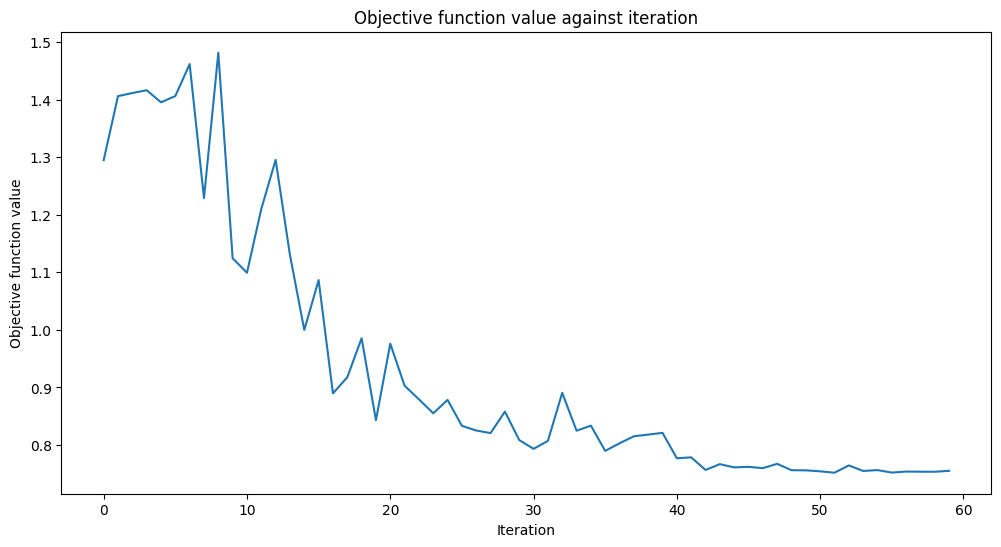

In [7]:
# Step 2: Fit Model

# create empty array for callback to store evaluations of the objective function after each iteration
objective_func_vals = []

# plot the given figsize
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
opflow_classifier.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

#### 1.2.3 Predict using Model

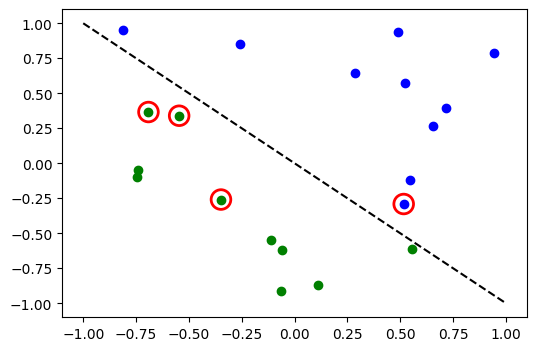

In [8]:
# Step 3: Predict using Model

# evaluate data points using predict
y_predict = opflow_classifier.predict(X)

# plot result
for x, y_target, y_p in zip(X, y, y_predict):
    if y_target == 1:
        # plots class 1 as blue datapoints
        plt.plot(x[0], x[1], "bo")
    else:
        # plots class -1 as green datapoints
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        # encircle wrongly classified points with red
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
# plot dotted black line as the classification line
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

#### 1.2.4 Evaluate Accuracy score

In [9]:
# Step 4: Evaluate Accuracy

# score of classifier
print(
    "The accuracy score of NeuralNetworkClassifier (TwoLayerQNN) is {}".format(
        opflow_classifier.score(X, y)
    )
)

The accuracy score of NeuralNetworkClassifier (TwoLayerQNN) is 0.8


Now, when the model is trained, we can explore the weights of the neural network. Please note, in the case of `TwoLayerQNN` the number of weights is defined by ansatz. And when no ansatz is passed, it defaults internally to using a `RealAmplitudes` quantum circuit of `reps=3`. More on TwoLayerQNN can be found in [this](https://qiskit.org/documentation/machine-learning/tutorials/01_neural_networks.html) tutorial.

In [10]:
opflow_classifier.weights

AttributeError: 'NeuralNetworkClassifier' object has no attribute 'weights'

### 1.3. Classification with `NeuralNetworkClassifier` using `CircuitQNN`

Next we will look at how a `CircuitQNN` can be used for classification within a `NeuralNetworkClassifier`. In this context, the `CircuitQNN` is expected to return $d$-dimensional probability vector as output, where $d$ denotes the number of classes. Sampling from a `QuantumCircuit` automatically results in a probability distribution and we just need to define a mapping from the measured bitstrings to the different classes. For binary classification we use the parity mapping.

In [11]:
# required imports
from qiskit_machine_learning.neural_networks import CircuitQNN
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit import QuantumCircuit

#### 1.3.1 Define the Model
For defining the model, we need to follow these steps:
1. Construct a parameterized quantum circuit
2. Use the quantum circuit to define the `CircuitQNN`
3. Use `CircuitQNN` in `NeuralNetworkClassifer`

To understand step 1 and 2 better, please refer the tutorial on QuantumNeuralNetworks [here](https://qiskit.org/documentation/machine-learning/tutorials/01_neural_networks.html)

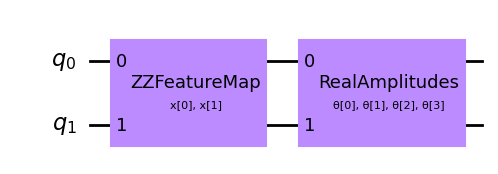

In [12]:
# Step 1: Construct a parameterized quantum circuit

# construct feature map
feature_map = ZZFeatureMap(num_inputs)  # num_inputs = 2

# construct ansatz
ansatz = RealAmplitudes(num_inputs, reps=1)

# construct a quantum circuit
qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))
qc.decompose().draw(output="mpl")

In [13]:
# parity maps bitstrings to 0 or 1 ( will be used as the interpreter in CircuitQNN)
# case 1: when the count of 1 in a bitstring is even, we get 0
# case 2: when the count of 1 in a bitstring is odd, we get 1
def parity(x):
    return "{:b}".format(x).count("1") % 2


# output shape
# it corresponds to the number of classes, possible outcomes of the (parity) mapping
# which is 2 in this case of binary classification.
output_shape = 2

In [14]:
# Step 2: Construct CircuitQNN

circuit_qnn = CircuitQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=output_shape,
    quantum_instance=quantum_instance,
)

In [15]:
# Step 3: Construct Neural Network Classifier

circuit_classifier = NeuralNetworkClassifier(
    neural_network=circuit_qnn, optimizer=COBYLA(maxiter=30), callback=callback_graph
)

#### 1.3.2 Fit the model

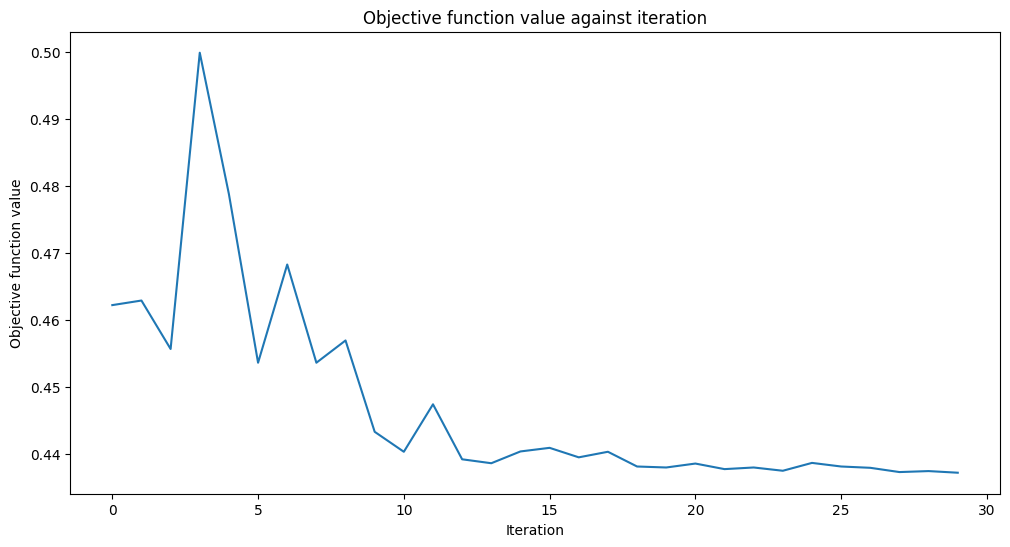

In [16]:
# Fit the Model

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []

# plot the given figsize
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
circuit_classifier.fit(X, y01)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

#### 1.3.3 Predict using the model

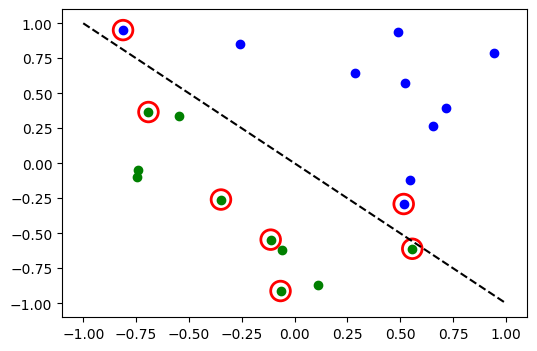

In [17]:
# Predit using the model

# evaluate data points
y_predict = circuit_classifier.predict(X)

# plot result
for x, y_target, y_p in zip(X, y01, y_predict):
    if y_target == 1:
        # plots class 1 as blue datapoints
        plt.plot(x[0], x[1], "bo")
    else:
        # plots class -1 as green datapoints
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        # encircle the wrongly classified points with red
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
# plot dotted black line as the classification line
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

#### 1.3.4 Evaluate Accuracy

In [18]:
# Evaluate Accuracy Score

# score of classifier
print(
    "The accuracy score of NeuralNetworkClassifier (CircuitQNN) is {}".format(
        circuit_classifier.score(X, y01)
    )
)

The accuracy score of NeuralNetworkClassifier (CircuitQNN) is 0.65


Again, once the model is trained we can take a look at the weights. As we set `reps=1` explicitly in our ansatz, we can see less parameters than in the previous model.

In [19]:
circuit_classifier.weights

AttributeError: 'NeuralNetworkClassifier' object has no attribute 'weights'

### 1.4. Classification using Variational Quantum Classifier (`VQC`)

The `VQC` is a special variant of the `NeuralNetworkClassifier` with a `CircuitQNN`. It applies a parity mapping (or extensions to multiple classes) to map from the bitstring to the classification, which results in a probability vector, which is interpreted as a one-hot encoded result. By default, it applies this the `CrossEntropyLoss` function that expects labels given in one-hot encoded format and will return predictions in that format too.

In [20]:
from qiskit_machine_learning.algorithms.classifiers import VQC

`Variational quantum classifier`

The variational quantum classifier (VQC) is a variational algorithm where the measured expectation value is interpreted as the output of a classifier. It is built upon the `NeuralNetworkClassifier`

Here, are the arguments taken by `VQC`:
1. num_qubits: The number of qubits
2. feature_map: The (parametrized) circuit to be used as a feature map
3. ansatz: The (parametrized) circuit to be used as an ansatz
4. loss: A target loss function to be used in training, default is cross_entropy
5. optimizer: An instance of an optimizer to be used in training, [COBYLA](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.COBYLA.html) is used over here
6. quantum_instance: The quantum instance to execute circuits on
7. callback: tracks how well optimization process is going on, callback_graph defined earlier is used here

In [21]:
# Step 1: Construct the Variational Quantum Classifier

# construct feature map, ansatz, and optimizer
feature_map = ZZFeatureMap(num_inputs)
ansatz = RealAmplitudes(num_inputs, reps=1)

# construct variational quantum classifier
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    loss="cross_entropy",
    optimizer=COBYLA(maxiter=30),
    quantum_instance=quantum_instance,
    callback=callback_graph,
)

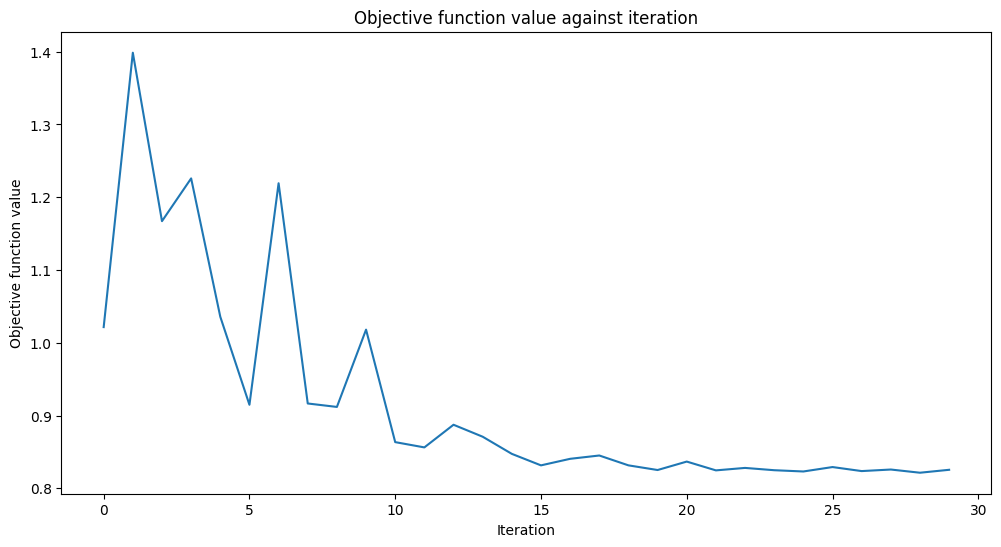

In [22]:
# Step 2: Fit the Model

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []

# plot the given figsize
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(X, y_one_hot)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

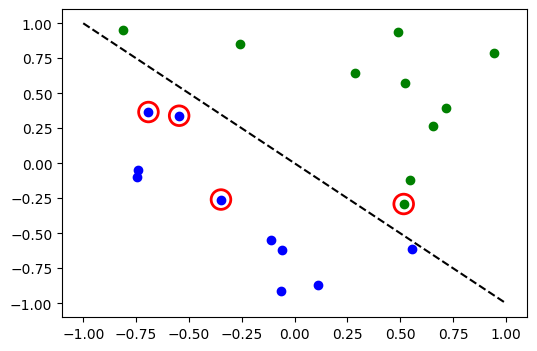

In [23]:
# Step 3: Predict using Model

# evaluate data points
y_predict = vqc.predict(X)

# plot result
for x, y_target, y_p in zip(X, y_one_hot, y_predict):
    if y_target[0] == 1:
        # plots class 1 as blue datapoints
        plt.plot(x[0], x[1], "bo")
    else:
        # plots class -1 as blue datapoints
        plt.plot(x[0], x[1], "go")
    if not np.all(y_target == y_p):
        # encircle the wrongly classified points with red
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
# plot dotted black line as the classification line
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

In [24]:
# Step 4: Evaluate Accuracy Score

# score of classifier
print("The accuracy score of VQC is {}".format(vqc.score(X, y_one_hot)))

The accuracy score of VQC is 0.8


### 1.5. Multi-class classification with VQC

In this section we implement VQC to solve Multi-class classification. This example shows how to tackle more interesting problems in machine learning.

First, we generate an artificial dataset that contains samples of three classes. Of course, for sake of short training time we prepare a small dataset. We use `make_classification` from SciKit-Learn to generate a dataset. There are 10 samples in the dataset with 2 features, that means we can still have a nice plot of the dataset, as well as no redundant features (these are features are generated as a combinations of the other features). 

Also, we have 3 different classes in the dataset, points of each class are closest to the centroid of that class compared to others. We set class separation to `2.0`, a slight increase from the default value of `1.0` to ease the classification problem.

Once the dataset is generated we scale the features into the range `[0, 1]`.

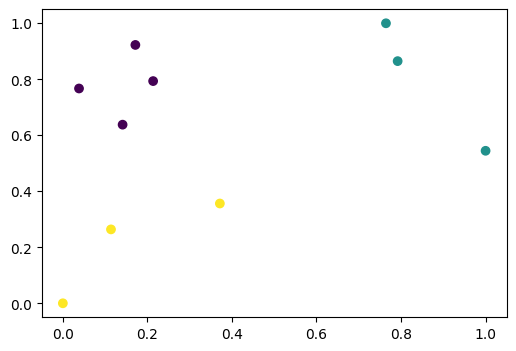

In [25]:
# Preparing the Dataset

from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler

# All settings are according to the explanation above
X, y = make_classification(
    n_samples=10,
    n_features=2,
    n_classes=3,
    n_redundant=0,
    n_clusters_per_class=1,
    class_sep=2.0,
    random_state=algorithm_globals.random_seed,
)
X = MinMaxScaler().fit_transform(X)

# Let's see how our dataset looks like.
plt.scatter(X[:, 0], X[:, 1], c=y)

In [26]:
# We can transform labels and make them categorical
y_cat = np.empty(y.shape, dtype=str)
y_cat[y == 0] = "A"
y_cat[y == 1] = "B"
y_cat[y == 2] = "C"
print(y_cat)

['A' 'A' 'B' 'C' 'C' 'A' 'B' 'B' 'A' 'C']


We create an instance of `VQC` similar to the previous example, but in this case we pass a minimal set of parameters. Instead of feature map and ansatz we pass just the number of qubits that is equal to the number of features in the dataset, an optimizer with a low number of iteration to reduce training time, a quantum instance, and a callback to observe progress. The feature map and ansatz get the default values.

In [27]:
# Construct VQC

vqc = VQC(
    num_qubits=2,
    optimizer=COBYLA(maxiter=30),
    quantum_instance=quantum_instance,
    callback=callback_graph,
)

Start the training process in the same way as in previous examples.

In [28]:
# Fit the model

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []

# plot the given figsize
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(X, y_cat)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


QiskitMachineLearningError: "Shapes don't match, predict: (10, 10), target: (10, 3)!"

Let see the output of the `predict` method and compare the output with the ground truth.

In [29]:
# Predict using the model

predict = vqc.predict(X)
print(f"Predicted labels: {predict}")
print(f"Ground truth:     {y_cat}")

QiskitMachineLearningError: 'Model needs to be fit to some training data first!'

Despite we had the low number of iterations, we achieved quite a good score. 

In [30]:
# Evaluate Accuracy

# score classifier
print("The accuracy score of VQC is {}".format(vqc.score(X, y_cat)))

QiskitMachineLearningError: 'Model needs to be fit to some training data first!'

## 2. Regression

In this section we use `NeuralNetworkRegressor` and `VQR` on linear regression. In simplicity, regression estimates the relationship between an independent variable and a dependent variable using a straight line of best fit.

Steps that will be followed in the regression section
1. First, we prepare a simple regression dataset to illustrate the following algorithms. 
2. Next we implement `NeuralNetworkRegressor` to solve the machine learning problem using `OpflowQNN` 
4. Afterwards we implement `VQR` to solve the same problem. `VQR` is essentially a wrapper class that inherits from `NeuralNetworkRegressor` and pre configures a parameterized circuit. 

### 2.1. Dataset generation for regression

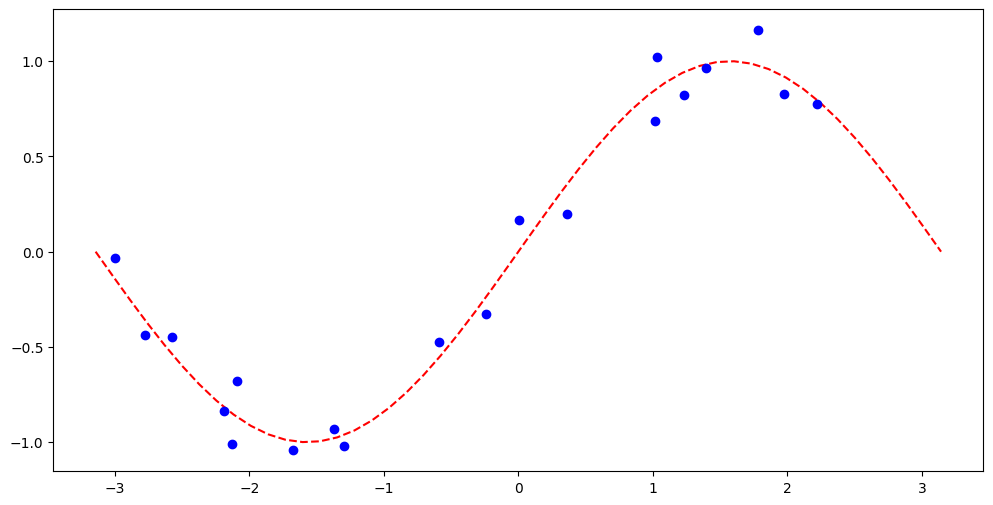

In [31]:
# Generating a sinusoidal dataset

num_samples = 20
eps = 0.2
lb, ub = -np.pi, np.pi
X_ = np.linspace(lb, ub, num=50).reshape(50, 1)
f = lambda x: np.sin(x)

X = (ub - lb) * algorithm_globals.random.random([num_samples, 1]) + lb
y = f(X[:, 0]) + eps * (2 * algorithm_globals.random.random(num_samples) - 1)

plt.plot(X_, f(X_), "r--")
plt.plot(X, y, "bo")
plt.show()

### 2.2. Regression with `NeuralNetworkRegressor` using `OpflowQNN` 

Here we restrict to regression with an `OpflowQNN` that returns values in $[-1, +1]$. More complex and also multi-dimensional models could be constructed, also based on `CircuitQNN` but that exceeds the scope of this tutorial.

In [32]:
from qiskit.circuit import Parameter
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit.algorithms.optimizers import L_BFGS_B

Steps to implement for solving regression using `NeuralNetworkRegressor` with `TwoLayerQNN`
1. Construct TwoLayerQNN using simple feature map and ansatz
2. Construct `NeuralNetworkRegressor`
3. Fit the model
4. Predict using the model
5. Evaluate accuracy

#### 2.2.1 Construct TwoLayerQNN

In [33]:
# Step 1.1: Construct simple feature map, with Ry gate rotating at 'x' degree
param_x = Parameter("x")
feature_map = QuantumCircuit(1, name="fm")
feature_map.ry(param_x, 0)
feature_map.draw()

┌───────┐
q: ┤ Ry(x) ├
   └───────┘

In [34]:
# Step 1.2: Construct simple ansatz, with Ry gate rotating at 'y' degree
param_y = Parameter("y")
ansatz = QuantumCircuit(1, name="vf")
ansatz.ry(param_y, 0)
ansatz.draw()

┌───────┐
q: ┤ Ry(y) ├
   └───────┘

In [35]:
# Step 1.3: Construct QNN
regression_opflow_qnn = TwoLayerQNN(
    num_qubits=1, feature_map=feature_map, ansatz=ansatz, quantum_instance=quantum_instance
)

#### 2.2.2 Construct NeuralNetworkRegressor

NeuralNetworkRegressor is a quantum neural network regressor which implements Scikit-Learn compatible methods for regression using an optimizer which is [SLSQP](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.SLSQP.html) by default but is set to [L_BFGS_B](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.L_BFGS_B.html) in the following example.

In [36]:
# Step 2: Construct the regressor from the neural network

regressor = NeuralNetworkRegressor(
    neural_network=regression_opflow_qnn,  # Specify quantum neural network
    loss="squared_error",  # specify loss function
    optimizer=L_BFGS_B(maxiter=5),  # specify optimizer
    callback=callback_graph,  # Specify function for viewing progress of model at each iteration
)

#### 2.2.3 Fit the model

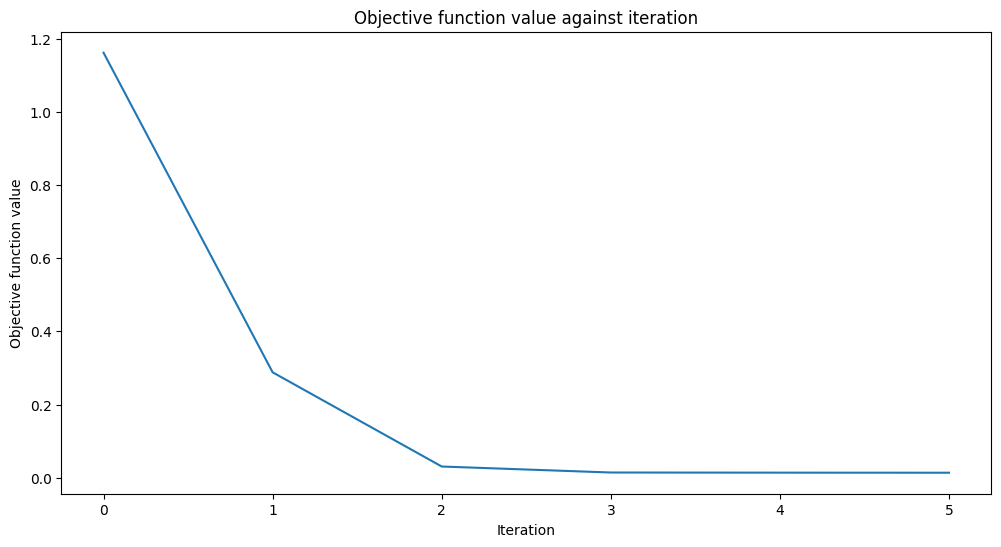

In [37]:
# Step 3: Fit the model

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []

# plot the given figsize
plt.rcParams["figure.figsize"] = (12, 6)

# fit to data
regressor.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

#### 2.2.4 Predict using the model

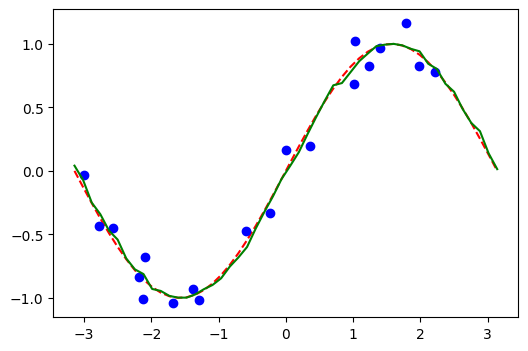

In [38]:
# Step 4: Predict using the model

# plot target function
plt.plot(X_, f(X_), "r--")

# plot data
plt.plot(X, y, "bo")

# plot fitted line
y_ = regressor.predict(X_)
plt.plot(X_, y_, "g-")
plt.show()

#### 2.2.5 Evaluate accuracy

In [39]:
# Evaluate accuracy

# score the result
regressor.score(X, y)
print(
    "The accuracy score of NeuralNetworkRegressor using TwoLayerQNN is {}".format(
        regressor.score(X, y)
    )
)

The accuracy score of NeuralNetworkRegressor using TwoLayerQNN is 0.977064014713864


Similarly to the classification models, we can obtain an array of trained weights by querying a corresponding property of the model. In this model we have only one parameter defined as `param_y` above.

In [40]:
regressor.weights

AttributeError: 'NeuralNetworkRegressor' object has no attribute 'weights'

### 2.3. Regression with the Variational Quantum Regressor (`VQR`)

Similar to the `VQC` for classification, the `VQR` is a special variant of the `NeuralNetworkRegressor` with a `OpflowQNN`. By default it considers the `L2Loss` function to minimize the mean squared error between predictions and targets.

In [41]:
# Step 1: Construct Variational Quantum Regressor

vqr = VQR(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=L_BFGS_B(maxiter=5),
    quantum_instance=quantum_instance,
    callback=callback_graph,
)

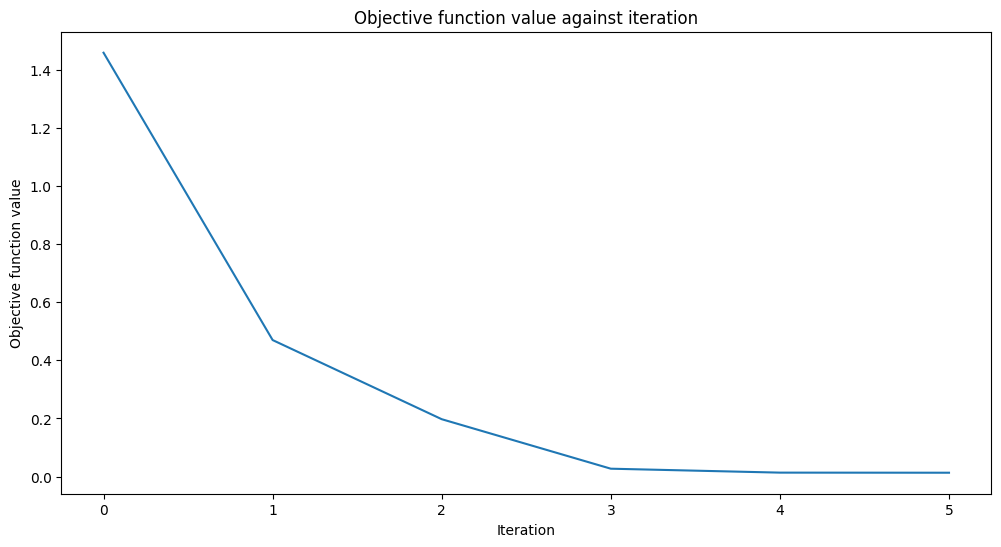

In [42]:
# Step 2: Fit the model

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []

# plot the given figsize
plt.rcParams["figure.figsize"] = (12, 6)

# fit regressor
vqr.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

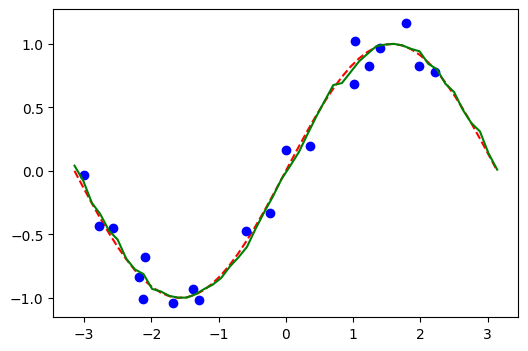

In [43]:
# Step 3: Predict using the model

# plot target function
plt.plot(X_, f(X_), "r--")

# plot data
plt.plot(X, y, "bo")

# plot fitted line
y_ = vqr.predict(X_)
plt.plot(X_, y_, "g-")
plt.show()

In [44]:
# Step 4: Evaluate accuracy

# score the result
regressor.score(X, y)
print("The accuracy score of VQR is {}".format(vqr.score(X, y)))

The accuracy score of VQR is 0.9771028080602604


## What was learned

In this tutorial, we understood the quantum version of the first supervised machine learning problems we come across in literature, namely classification and regression. We implement solution for classification using `NeuralNetworkClassifier` and it's variational wrapper `VQC`, similarly for regression we use `NeuralNetworkRegressor` and it's variational wrapper `VQC`. Further, to make `NeuralNetworkClassifier` and `NeuralNetworkRegressor` work we use `Quantum Neural Networks`, which were introduced in [this](https://qiskit.org/documentation/machine-learning/tutorials/01_neural_networks.html) tutorial.

In [45]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright